In [1]:
from funcs import *
from tqdm import tqdm
import matplotlib
import string
import plotly.graph_objs as go
from scipy import ndimage, datasets
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import Button, Slider
%matplotlib widget

In [2]:
world_pop = gpd.read_file('./data/pop.geo.json')
world_pop['POP2005']=world_pop['POP2005'].astype(float)
world_pop['area']=  world_pop.to_crs(6933).area.astype(float)*0.000001
world_pop['density'] = (world_pop['POP2005'].div(world_pop['area']))

In [3]:
country_name_index = {}
index_country_name = {}
for i in range(len(world_pop)):
    row_i = world_pop.iloc[i]
    country_name_index.update({row_i['NAME']:i})
    index_country_name.update({i:row_i['NAME']})

In [4]:
polygons_ = get_polygons(world_pop['geometry'])
source_polygons = get_source_polygons(world_pop['geometry'])
N_vec_ = world_pop['POP2005'].values
for i in range(len(N_vec_)):
    if pd.isna(N_vec_[i]):
        N_vec_[i]=1.0
Names_ = world_pop['NAME'].values
Areas_ = world_pop['area'].values

In [5]:
hx = 1.0
hy = 1.0

In [6]:
bounds_ = bounds_by_polygons(polygons_)
xgrid,ygrid = make_grids(hx,hy,bounds_)
Nx = len(xgrid)
Ny = len(ygrid)

In [7]:
bounds_

[[-180.00018310546875, 180.0], [-90.0, 83.62303161621094]]

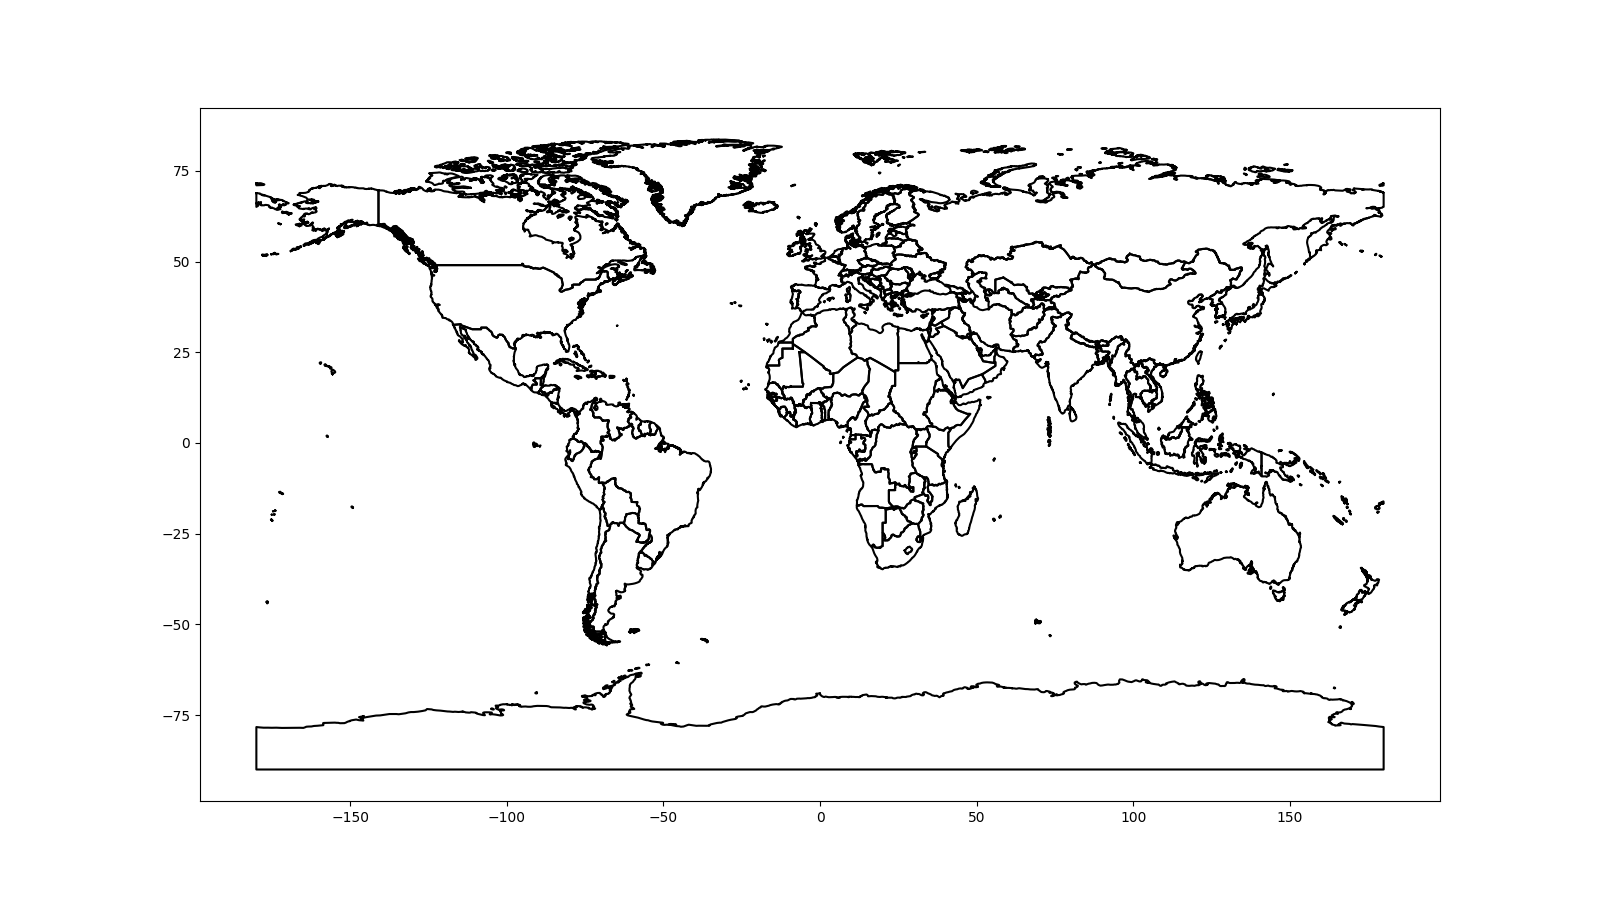

In [8]:
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
for i in range(len(polygons_ )):
    ax.plot(polygons_[i][0],polygons_[i][1],c='k')

In [9]:
masks_per_state = get_binary_mask_per_state_cv2(source_polygons,
                                xgrid, ygrid)
mask_of_earth = CUPmasks(masks_per_state)
mask_of_water = np.logical_not(mask_of_earth)

100%|██████████| 211/211 [00:01<00:00, 210.96it/s]


In [10]:
masks_with_N = [masks_per_state[i].astype(np.float64)*N_vec_[i] for i in range(len(masks_per_state))]

In [11]:
mask_of_earth_N = None 
for i in range(len(masks_with_N)):
    if mask_of_earth_N is None:
        mask_of_earth_N = masks_with_N[i]
    else:
        mask_of_earth_N += masks_with_N[i]

In [12]:
cities = pd.read_csv('./data/worldcities.csv')

In [13]:
cities_mask = np.zeros(shape=(len(xgrid),len(ygrid)),dtype=np.float64)
for i in range(len(cities)):
    x = cities.iloc[i]['lng']
    y = cities.iloc[i]['lat']
    z = cities.iloc[i]['population']
    xi = int((x-xgrid[0])/(xgrid[-1]-xgrid[0])*(len(xgrid)-1))
    yi = int((y-ygrid[0])/(ygrid[-1]-ygrid[0])*(len(ygrid)-1))
    if pd.isna(z):
        z = 1.0
    cities_mask[xi][yi] +=  z

In [14]:
poly_per_state = get_polygons_per_state(world_pop['geometry'])

In [15]:
borders_per_state = get_binary_mask_per_state(poly_per_state,xgrid,ygrid,hx,hy)
all_borders_ = CUPmasks(borders_per_state)
# all_borders_ = ndimage.median_filter(all_borders_, size=2)
kmask = 1.0-np.logical_or(all_borders_.astype(bool), mask_of_water).astype(np.float64)

100%|██████████| 211/211 [00:03<00:00, 54.64it/s]


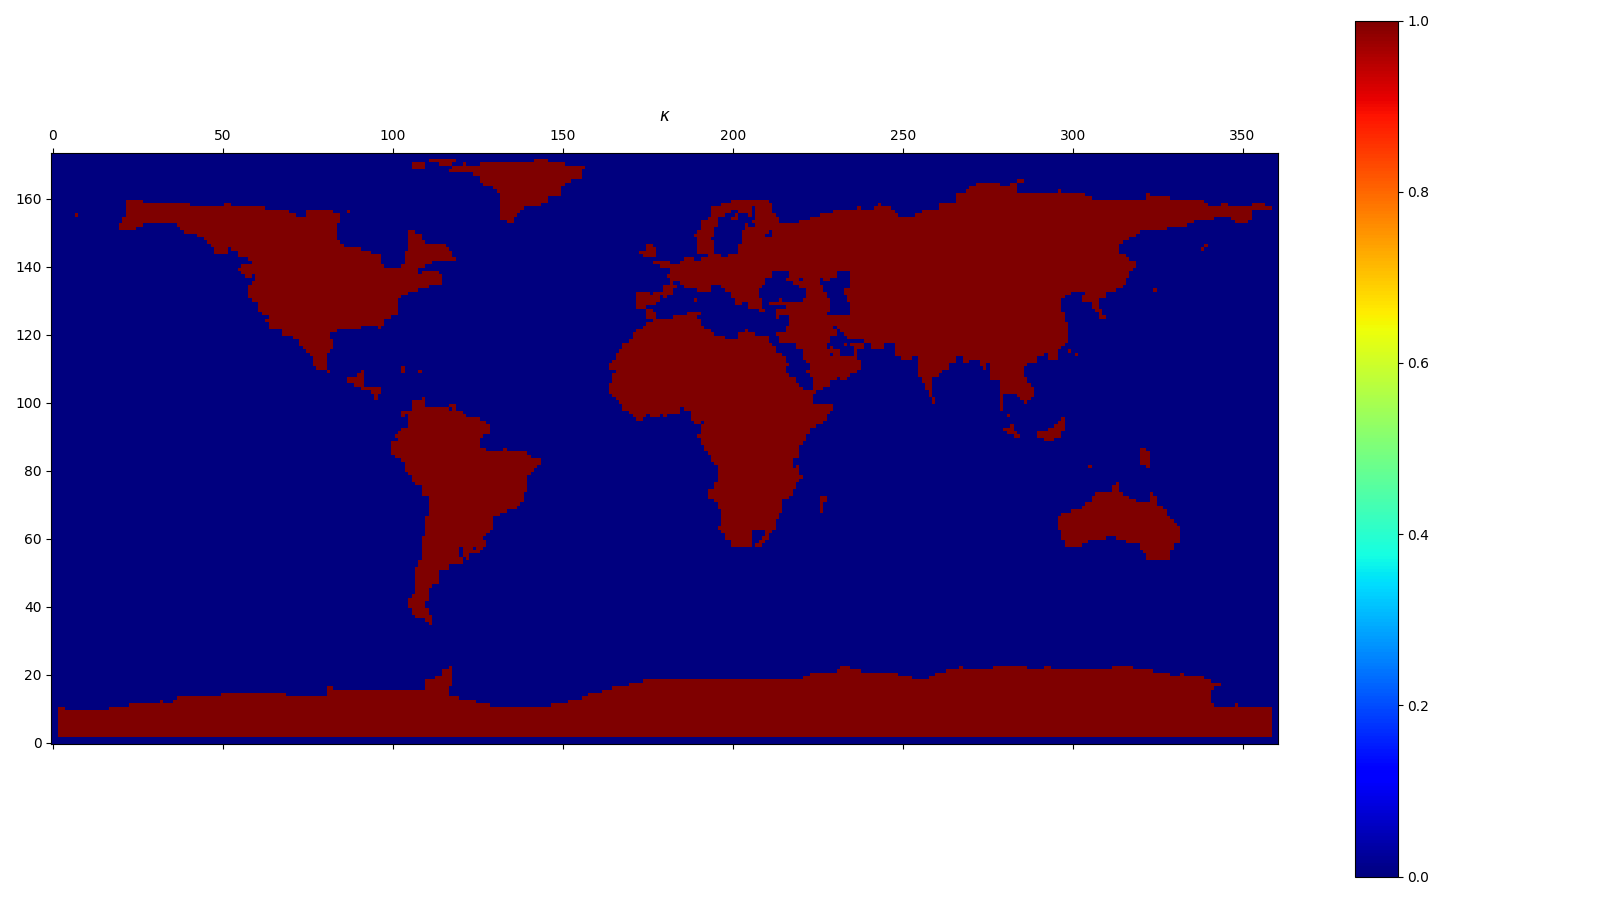

In [16]:
border_intersection = np.zeros(shape=(len(xgrid),len(ygrid)),dtype=np.float64)
for i in range(len(borders_per_state)):
    for j in range(len(borders_per_state)):
        if i==j:
            continue
        ib = borders_per_state[i]
        jb = borders_per_state[j]
        intersection = ib*jb
        border_intersection += intersection
border_intersection[border_intersection>0.0] = 1.0
kmaskopen = np.zeros(shape=(len(xgrid),len(ygrid)),dtype=np.float64)
for i in range(Nx):
    for j in range(Ny):
        is_water = False
        xi = i
        yi = j 
        if(mask_of_water[xi][yi] or mask_of_water[np.minimum(xi+1,Nx-1)][yi] or mask_of_water[np.maximum(xi-1,0)][yi] or mask_of_water[xi][np.maximum(yi-1,0)] or mask_of_water[np.minimum(xi+1,Nx-1)][np.maximum(yi-1,0)] or mask_of_water[np.maximum(xi-1,0)][np.maximum(yi-1,0)] or mask_of_water[xi][np.minimum(yi+1,Ny-1)] or mask_of_water[np.minimum(xi+1,Nx-1)][np.minimum(yi+1,Ny-1)] or mask_of_water[np.maximum(xi-1,0)][np.minimum(yi+1,Ny-1)]):
            is_water = True
        if not is_water:
            kmaskopen[i][j] = (1.0-border_intersection[i][j])*all_borders_[i][j]
        elif all_borders_[i][j] == 1.0: 
            kmaskopen[i][j] = 1.0
        else:
            kmaskopen[i][j] = 0.0
all_borders_open_ = np.copy(kmaskopen)
kmaskopen = 1.0-np.logical_or(kmaskopen.astype(bool), mask_of_water).astype(np.float64)
fig, ax = plt.subplots()
fig.set_size_inches(16,9)
cax = ax.matshow((kmaskopen).T,cmap=matplotlib.cm.jet)
cbar = fig.colorbar(cax)
ax.invert_yaxis()
ax.set_title(r'$\kappa$')
fig.subplots_adjust(left=0.0, bottom=0.0)
fig.tight_layout()

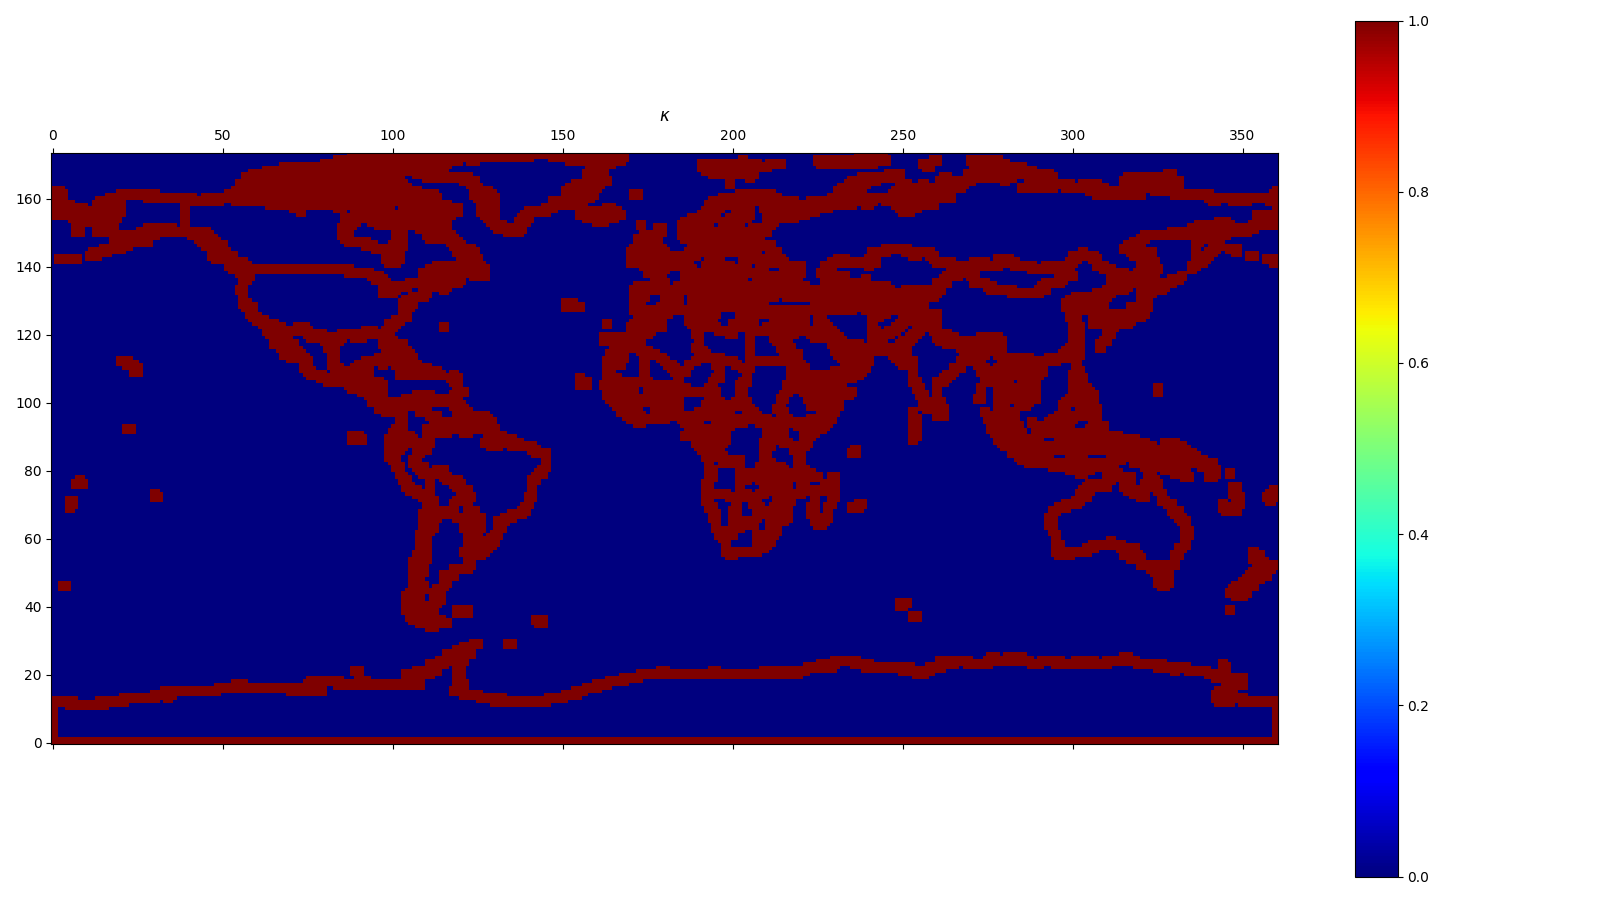

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(16,9)
cax = ax.matshow((all_borders_).T,cmap=matplotlib.cm.jet)
cbar = fig.colorbar(cax)
ax.invert_yaxis()
ax.set_title(r'$\kappa$')
fig.subplots_adjust(left=0.0, bottom=0.0)
fig.tight_layout()

In [18]:
u_nu = np.zeros(shape=(Nx,Ny))
total_unaccounted = 0.0
total_sum_ = 0.0
internal_mask_per_state = []
internal_index_cnames_ = {}
internal_cnames_index_ = {}
tmp_ind = 0
for i in range(len(masks_per_state)):
    state_mask = masks_per_state[i].astype(bool)
    state_border_mask = borders_per_state[i].astype(bool)
    internal_mask_ = np.logical_and(np.logical_not(state_border_mask), state_mask).astype(np.float64)
    border_people_amt_ = np.sum(cities_mask*state_border_mask.astype(np.float64))
    vertex_amt_internal_ = np.sum(internal_mask_)
    if vertex_amt_internal_ ==0.0:
        total_unaccounted += border_people_amt_
        continue
    total_sum_ += border_people_amt_
    internal_people_ = internal_mask_*cities_mask + border_people_amt_/vertex_amt_internal_*internal_mask_
    u_nu += internal_people_
    internal_mask_per_state.append(internal_mask_)
    internal_index_cnames_.update({tmp_ind:index_country_name[i]})
    internal_cnames_index_.update({index_country_name[i]:tmp_ind})
    tmp_ind +=1
all_internal_masks_ = CUPmasks(internal_mask_per_state)
where_not_zero = u_nu !=0.0
vertex_amnt_where_not_zero = np.sum(where_not_zero)
u_nu[where_not_zero] += total_unaccounted/vertex_amnt_where_not_zero
u_nu[where_not_zero] = u_nu[where_not_zero]/np.sum(u_nu)*np.sum(N_vec_)


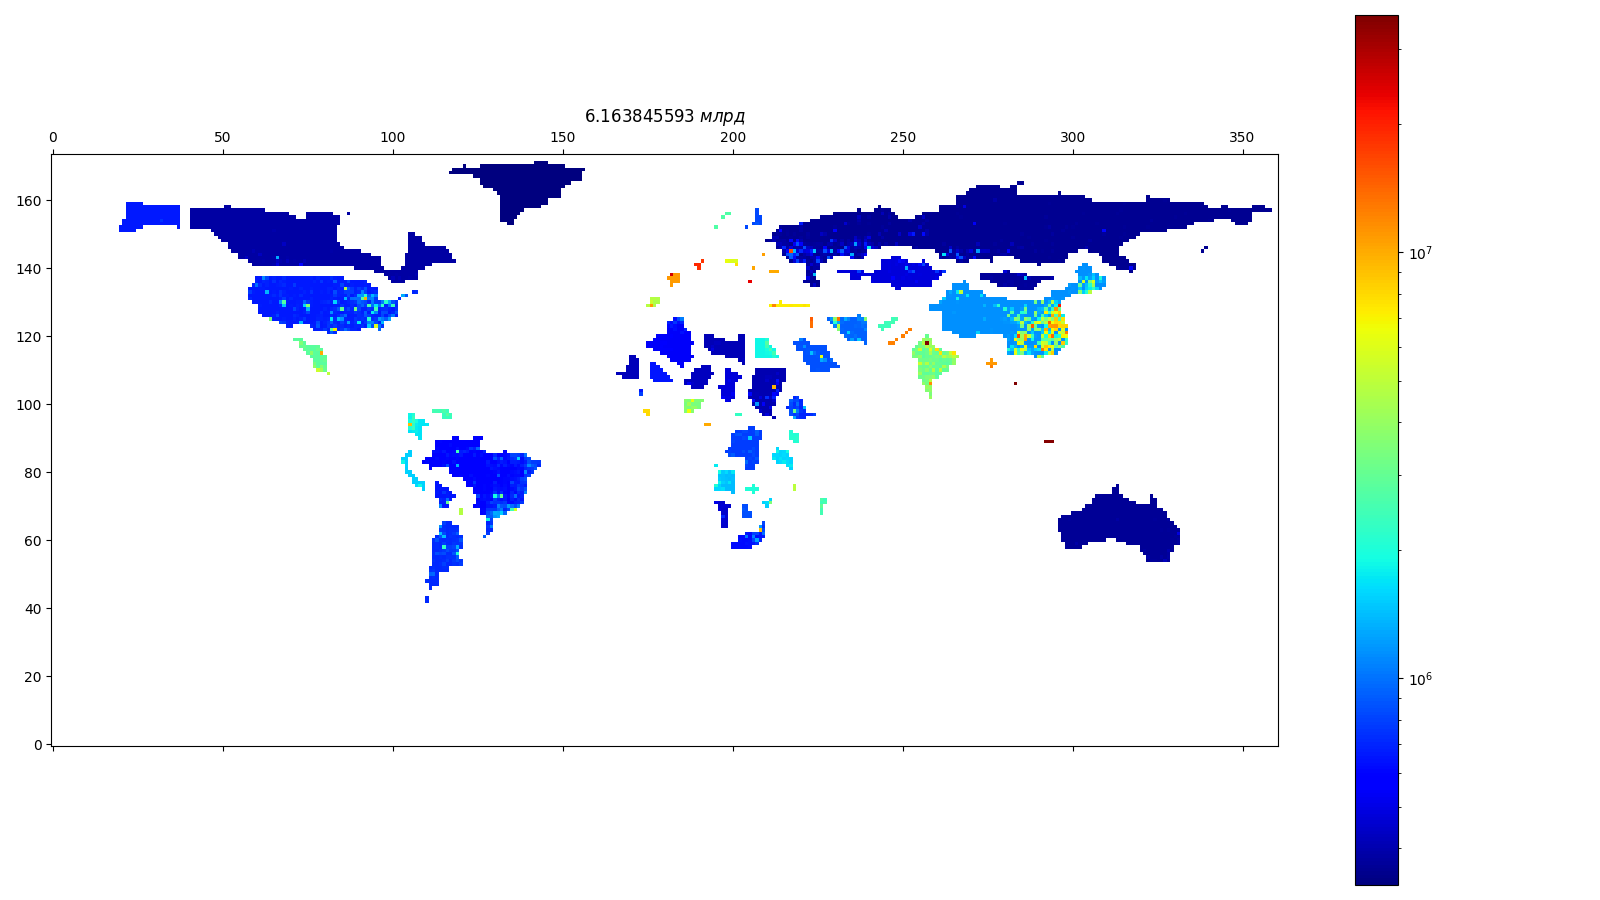

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(16,9)
cax = ax.matshow(u_nu.T,cmap=matplotlib.cm.jet,norm=matplotlib.colors.LogNorm())
cbar = fig.colorbar(cax)
ax.invert_yaxis()
ax.set_title(r'${} \ млрд$'.format(np.sum(u_nu)/10**9))
fig.subplots_adjust(left=0.0, bottom=0.0)
fig.tight_layout()

In [20]:
@jit(nopython=True)
def F(uij, current_sum):
    C0 = 279.0*10**9
    return uij*current_sum/C0

# @jit(nopython=True)
# def F(t,i,j,intmask):
#     C0 = 279.0*10**9
#     T0 = 2048.37
#     return C0/(T0-t)**2/60.0*intmask[i][j]

# @jit(nopython=True)
# def F(uij):
#     C0 = 279.0*10**10
#     return uij**2/C0

# @jit(nopython=True)
# def F(uij, current_sum):
#     return 0.0

# @jit(nopython =True)
# def D(x,y,u,kmask,xindex,yindex,F_at_point):
#     return kmask[xindex][yindex]*np.maximum(F_at_point,1.0)

# @jit(nopython =True)
# def D(x,y,u,kmask,xindex,yindex,F_at_point):
#     return kmask[xindex][yindex]*F_at_point/10**5
@jit(nopython =True)
def D(x,y,u,kmask,xindex,yindex,F_at_point):
    return kmask[xindex][yindex]*F_at_point/10**5

    # return kmask[xindex][yindex]

# @jit(nopython =True)
# def D(x,y,u,kmask,xindex,yindex,F_at_point):
#     return kmask[xindex][yindex]*F_at_point/10**5


@jit(nopython=True)
def solve(Nx,Ny,Nt,hx,hy,tau,t,x,y,u_,years_,water_mask_,earth_,kmask,intmask,borders_mask):
    solutions = np.zeros(shape=(len(years_),Nx,Ny))
    solutions[0] = np.copy(u_)
    u = np.copy(u_)    
    B = np.zeros(shape=(Nx,))
    A = np.zeros(shape=(Nx, Nx))

    By = np.zeros(shape=(Ny,))
    Ay = np.zeros(shape=(Ny, Ny))
    end_ = False
    l_ = 1
    u_next = np.zeros(shape=(Nx,Ny))
    u_tau = np.zeros(shape=(Nx,Ny))
    iters_ = 5
    for k in range(Nt-1):
        u_s = np.copy(u)       
        current_sum = np.sum(u_s)
        if np.isnan(current_sum) or np.isinf(current_sum):
            print('last bad try')
            print(f'nan {np.isnan(current_sum)}')
            print(f'inf {np.isinf(current_sum)}')
            print(f'num of nan {np.sum(np.isnan(u_s))}')
            # FloatDistr(u_s.flatten())
            print(k,Nt, t[k], current_sum/10**9) 
            return solutions[:l_]
        print(k,Nt, t[k], current_sum/10**9) 
        
        for j in range(1,Ny-1):
            x_sums = []
            for s in range(iters_):
                u_s = None
                if s == 0:
                    u_s = np.copy(u) 
                else:
                    u_s = np.copy(u_next)
                sum_s = np.sum(u_s)
                x_sums.append(sum_s)
                A[0][0] = 1.0
                A[Nx-1][Nx-1] = 1.0 
                
                for i in range(1,Nx-1):
                    if borders_mask[i][j] == 1:
                        if intmask[i+1][j] == 1:
                            A[i][i-1] = 0.0
                            A[i][i] = -1.0/hx
                            A[i][i+1] = 1.0/hx
                            continue
                        elif intmask[i-1][j] == 1:
                            A[i][i-1] = -1.0/hx
                            A[i][i] = 1.0/hx
                            A[i][i+1] = 0.0
                            continue
                    A[i][i-1] = 1.0/4.0/hx**2*(D(x[i+1],y[j],u_s[i+1][j],kmask,i+1,j,F(u_s[i+1][j],sum_s))-D(x[i-1],y[j],u_s[i-1][j],kmask,i-1,j,F(u_s[i-1][j],sum_s))) - 1.0/hx**2*D(x[i],y[j],u_s[i][j],kmask,i,j,F(u_s[i][j],sum_s))
                    A[i][i]   = 2.0/tau+2.0/hx**2*D(x[i],y[j],u_s[i][j],kmask,i,j,F(u_s[i][j],sum_s))
                    A[i][i+1] = -1.0/4.0/hx**2*(D(x[i+1],y[j],u_s[i+1][j],kmask,i+1,j,F(u_s[i+1][j],sum_s)) - D(x[i-1],y[j],u_s[i-1][j],kmask,i-1,j,F(u_s[i-1][j],sum_s))) - 1.0/hx**2*D(x[i],y[j],u_s[i][j],kmask,i,j,F(u_s[i][j],sum_s))
                B[0] = 0.0
                B[Nx-1] = 0.0
                for i in range(1,Nx-1):
                    if borders_mask[i][j] == 1:
                        B[i] = 0.0
                    else:
                        B[i] = F(u_s[i][j],sum_s)+2.0/tau*u[i][j] + \
                            1.0/(4.0*hy**2)*(D(x[i],y[j+1],u[i][j+1],kmask,i,j+1,F(u[i][j+1],current_sum))-D(x[i],y[j-1],u[i][j-1],kmask,i,j-1,F(u[i][j-1],current_sum)))*(u[i][j+1]-u[i][j-1])+\
                            1.0/(hy**2)*D(x[i],y[j],u[i][j],kmask,i,j,F(u[i][j],current_sum))*(u[i][j+1]-2.0*u[i][j]+u[i][j-1])
                u_next[:,j], code_of_error = progonka(A,B)
                if code_of_error == 1:
                    solutions[:l_]

        u_tau_pola = np.copy(u_next)
        sum2= np.sum(u_tau_pola)
        for i in range(1,Nx-1):

            for s in range(iters_):
                u_s = None
                if s == 0:
                    u_s = np.copy(u_tau_pola) 
                else:
                    u_s = np.copy(u_tau)
                sum_s = np.sum(u_s)
                Ay[0][0] = 1.0
                Ay[Ny-1][Ny-1] = 1.0
                for j in range(1,Ny-1):
                    if borders_mask[i][j] == 1:
                        if intmask[i][j+1] == 1:
                            Ay[j][j-1] = 0.0
                            Ay[j][j] = -1.0/hy
                            Ay[j][j+1] = 1.0/hy
                            continue
                        elif intmask[i][j-1] == 1:
                            Ay[j][j-1] = -1.0/hy
                            Ay[j][j] = 1.0/hy
                            Ay[j][j+1] = 0.0
                            continue
                    Ay[j][j-1] = 1.0/(4.0*hy**2)*D(x[i],y[j+1],u_s[i][j+1],kmask,i,j+1,F(u_s[i][j+1],sum_s)) - 1.0/(4.0*hy**2)*D(x[i],y[j-1],u_s[i][j-1],kmask,i,j-1,F(u_s[i][j-1],sum_s)) - 1.0/hy**2*D(x[i],y[j],u_s[i][j],kmask,i,j,F(u_s[i][j],sum_s))
                    Ay[j][j]   = 2.0/tau+2.0/(hy**2)*D(x[i],y[j],u_s[i][j],kmask,i,j,F(u_s[i][j],sum_s))
                    Ay[j][j+1] = -1.0/(4.0*hy**2)*D(x[i],y[j+1],u_s[i][j+1],kmask,i,j+1,F(u_s[i][j+1],sum_s)) + 1.0/(4.0*hy**2)*D(x[i],y[j-1],u_s[i][j-1],kmask,i,j-1,F(u_s[i][j-1],sum_s)) - 1.0/hy**2*D(x[i],y[j],u_s[i][j],kmask,i,j,F(u_s[i][j],sum_s))

                By[0] = 0.0
                By[Ny-1] = 0.0
                for j in range(1,Ny-1):
                    if borders_mask[i][j] == 1:
                        By[j] = 0.0
                    else:
                        By[j] = F(u_s[i][j],sum_s)+2.0/tau*u_tau_pola[i][j] + \
                            1.0/(4.0*hx**2)*(D(x[i+1],y[j],u_tau_pola[i+1][j],kmask,i+1,j,F(u_tau_pola[i+1][j],sum2))-D(x[i-1],y[j],u_tau_pola[i-1][j],kmask,i-1,j,F(u_tau_pola[i-1][j],sum2)))*(u_tau_pola[i+1][j]-u_tau_pola[i-1][j])+\
                            1.0/(hx**2)*D(x[i],y[j],u_tau_pola[i][j],kmask,i,j,F(u_tau_pola[i][j],sum2))*(u_tau_pola[i+1][j]-2.0*u_tau_pola[i][j]+u_tau_pola[i-1][j])
                u_tau[i,:],code_of_error= progonka(Ay,By)
                if code_of_error == 1:
                    solutions[:l_]

        u = np.copy(u_tau)
        for ye_ in years_:
            if ye_ == t[k+1]:
                solutions[l_] = np.copy(u_tau)
                l_ +=1  
    return solutions

In [21]:
print(Nx,Ny,Nx*Ny)

361 174 62814


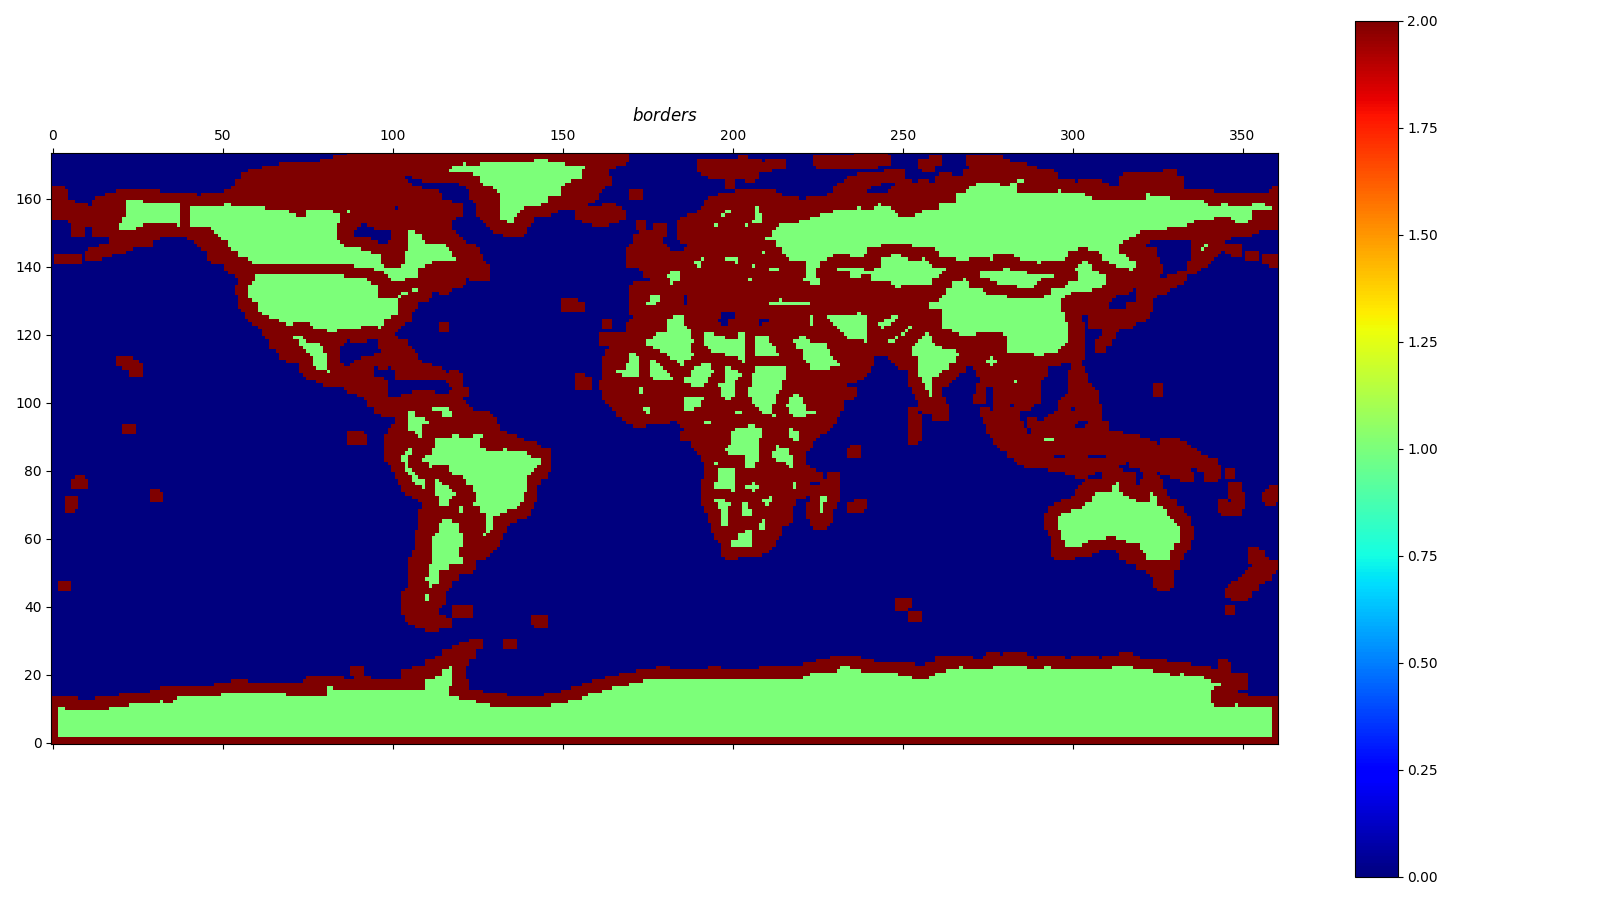

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(16,9)
cax = ax.matshow((kmask+2.0*all_borders_).T,cmap=matplotlib.cm.jet)
cbar = fig.colorbar(cax)
ax.invert_yaxis()
ax.set_title(r'$borders$')
fig.subplots_adjust(left=0.0, bottom=0.0)
fig.tight_layout()

In [23]:
tau = 0.1
T = 100.0
t0 = 2005.0
Nt = int((t0+T-t0)/tau) + 1
years_ = np.arange(t0,T+t0)
tgrid = np.linspace(start=t0, stop=t0+T,num=Nt)
t = np.copy(tgrid)
x = np.copy(xgrid)
y = np.copy(ygrid)
u_vec = solve(Nx,Ny,Nt,hx,hy,tau,t,x,y,u_nu,years_,mask_of_water.astype(np.float64),mask_of_earth.astype(np.float64),kmask,all_internal_masks_,all_borders_)

0 1001 2005.0 6.163845592999574
1 1001 2005.1 7.93821329095811
2 1001 2005.2 7.9117978794400425
3 1001 2005.3 7.91190416840127
4 1001 2005.4 7.9217555758394536
5 1001 2005.5 7.936211365094669
6 1001 2005.6 7.953177735831608
7 1001 2005.7 7.971668413037231
8 1001 2005.8 7.991170844780145
9 1001 2005.9 8.01139757114975
10 1001 2006.0 8.032176951055082
11 1001 2006.1 8.053400859980929
12 1001 2006.2 8.074997898810905
13 1001 2006.3 8.096918894112445
14 1001 2006.4 8.119128683029771
15 1001 2006.5 8.141601273061996
16 1001 2006.6 8.164316890804246
17 1001 2006.7 8.18726012603399
18 1001 2006.8 8.210418730542784
19 1001 2006.9 8.233782818791603
20 1001 2007.0 8.257344321022776
21 1001 2007.1 8.281096598485417
22 1001 2007.2 8.305034165027685
23 1001 2007.3 8.329152480050658
24 1001 2007.4 8.35344779048585
25 1001 2007.5 8.377917007306076
26 1001 2007.6 8.402557607009927
27 1001 2007.7 8.427367551639938
28 1001 2007.8 8.452345222907491
29 1001 2007.9 8.477489367300626
30 1001 2008.0 8.502799

In [24]:
total_error_ = 0.0
for i in range(len(u_vec)):
    total_error_ += np.sum(u_vec[i]*mask_of_water)
total_error_

0.0

In [25]:
for i in range(len(u_vec)):
    u_ = u_vec[i]
    if np.sum(u_<0.0):
        print(years_[i])

In [37]:
# fig,ax = plt.subplots()
# sums_ = [np.sum(el) for el in u_vec]
# sums__ = [(sums_[i]-sums_[0])/sums_[0]*100 for i in range(len(sums_))]
# ax.plot(years_[:len(u_vec)], sums__)
# # ax.set_yscale('symlog')
# ax.set_title('утечка без источника')

Text(0.5, 1.0, 'N(t), T0=2041.0')

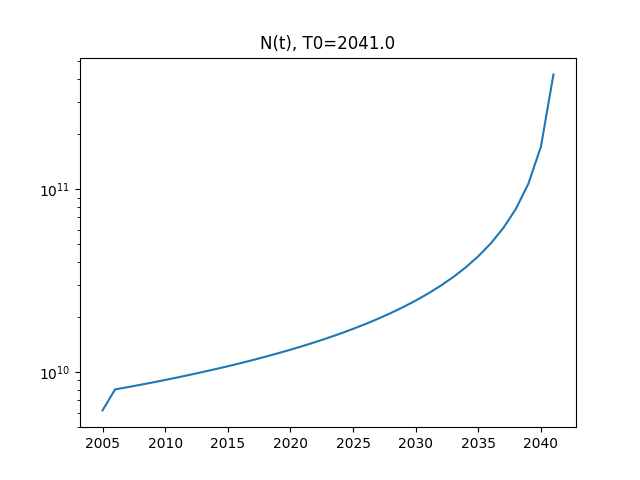

In [27]:
fig,ax = plt.subplots()
sums_ = [np.sum(el) for el in u_vec]
ax.plot(years_[:len(u_vec)], sums_)
ax.set_yscale('log')
ax.set_title(f'N(t), T0={years_[len(u_vec)-1]}')

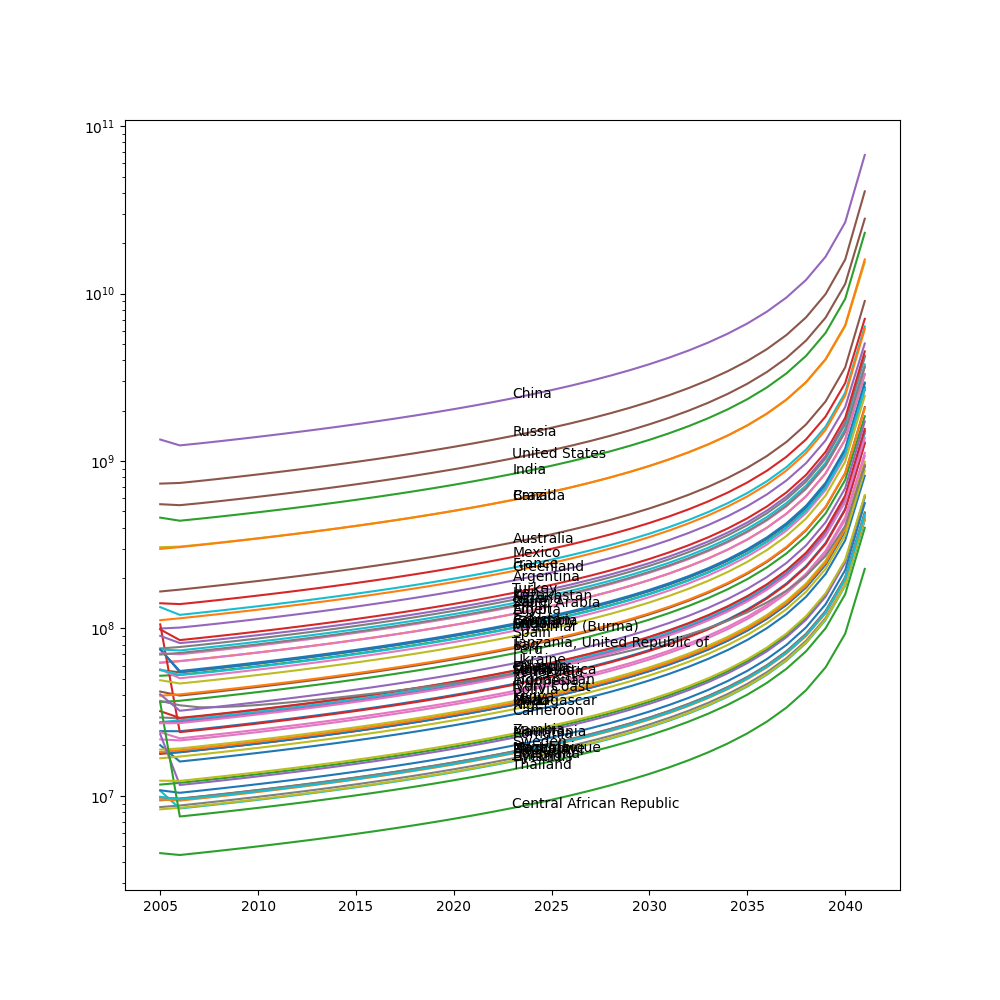

In [28]:
t_ = years_[:len(u_vec)]
fig,ax = plt.subplots()
fig.set_size_inches(10,10)
for i in range(len(internal_mask_per_state)):
    mask_ = internal_mask_per_state[i]
    name_ = internal_index_cnames_[i]
    sums_ = []
    for j in range(len(u_vec)):
        u_ = u_vec[j]
        sum_ = np.sum(u_*mask_)
        sums_.append(sum_)
    ax.plot(t_,sums_)
    ax.text(t_[int(len(t_)/2)], sums_[int(len(sums_)/2)], name_, fontsize = 10) 
ax.set_yscale('log')

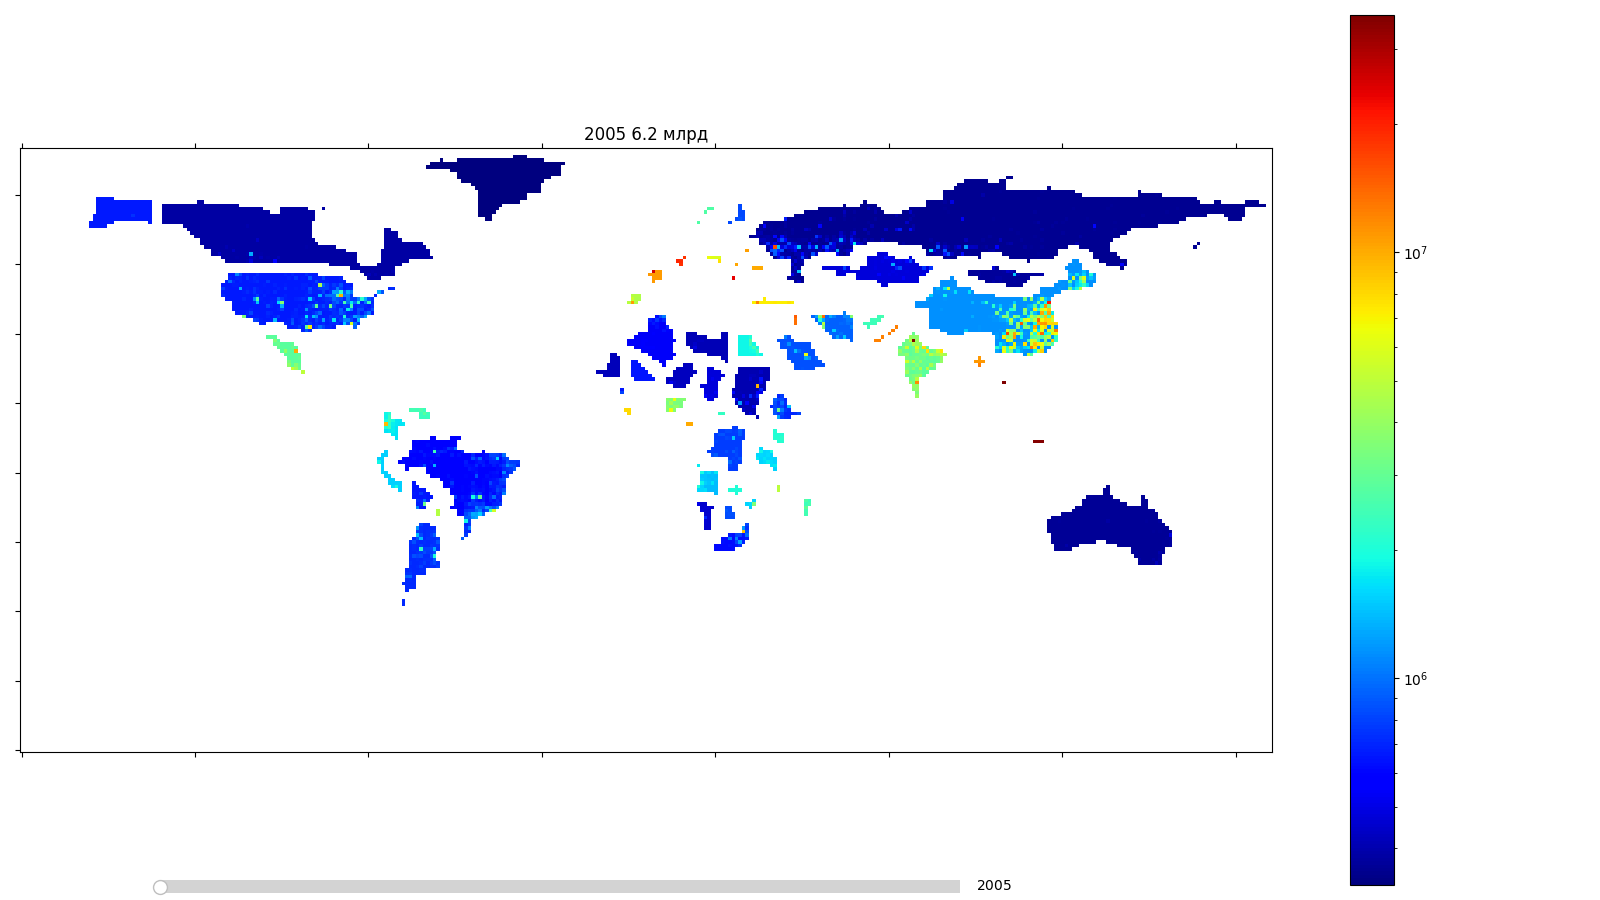

In [38]:
years_ = np.arange(t0,T+t0)
years_ = years_[:len(u_vec)]
fig, ax = plt.subplots()
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.set_size_inches(16,9)
cax = ax.matshow(u_vec[0].T,cmap=matplotlib.cm.jet,norm=matplotlib.colors.LogNorm())
# cax = ax.matshow(u_vec[0].T,cmap=matplotlib.cm.jet,norm=matplotlib.colors.SymLogNorm(linthresh=1000))
ax.set_title(f'{int(years_[0])} {np.round(np.sum(u_vec[0])/10**9,1)} млрд')
ax.invert_yaxis()
fig.subplots_adjust(left=0.0, bottom=0.0)
cbar = fig.colorbar(cax)
fig.tight_layout()

axfreq = fig.add_axes([0.1, 0.0, 0.5, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='',
    valmin=years_[0],
    valmax=years_[-1],
    valinit=years_[0]
)

def update(val):
    # ax.matshow(u_vec[int(val- years_[0])].T,cmap=matplotlib.cm.jet,norm=matplotlib.colors.LogNorm())
    cax.set_data(u_vec[int(val- years_[0])].T)
    ax.set_title(f'{int(val)} {np.round(np.sum(u_vec[int(val- years_[0])])/10**9,1)} млрд')
    fig.canvas.draw_idle()
    # plt.draw()

freq_slider.on_changed(update)
plt.show()

In [30]:
@jit(nopython=True)
def F(uij, current_sum):
    C0 = 279.0*10**9
    return uij*current_sum/C0

# @jit(nopython=True)
# def F(t,i,j,intmask):
#     C0 = 279.0*10**9
#     T0 = 2048.37
#     return C0/(T0-t)**2/60.0*intmask[i][j]

# @jit(nopython=True)
# def F(uij):
#     C0 = 279.0*10**10
#     return uij**2/C0

# @jit(nopython=True)
# def F(uij, current_sum):
#     return 0.0

# @jit(nopython =True)
# def D(x,y,u,kmask,xindex,yindex,F_at_point):
#     return kmask[xindex][yindex]*np.maximum(F_at_point,1.0)

# @jit(nopython =True)
# def D(x,y,u,kmask,xindex,yindex,F_at_point):
#     return kmask[xindex][yindex]*F_at_point/10**5
@jit(nopython =True)
def D(x,y,u,kmask,xindex,yindex,F_at_point):
    return kmask[xindex][yindex]

    # return kmask[xindex][yindex]

# @jit(nopython =True)
# def D(x,y,u,kmask,xindex,yindex,F_at_point):
#     return kmask[xindex][yindex]*F_at_point/10**5


@jit(nopython=True)
def solve(Nx,Ny,Nt,hx,hy,tau,t,x,y,u_,years_,water_mask_,earth_,kmask,intmask,borders_mask):
    solutions = np.zeros(shape=(len(years_),Nx,Ny))
    solutions[0] = np.copy(u_)
    u = np.copy(u_)    
    B = np.zeros(shape=(Nx,))
    A = np.zeros(shape=(Nx, Nx))

    By = np.zeros(shape=(Ny,))
    Ay = np.zeros(shape=(Ny, Ny))
    end_ = False
    l_ = 1
    u_next = np.zeros(shape=(Nx,Ny))
    u_tau = np.zeros(shape=(Nx,Ny))
    iters_ = 5
    for k in range(Nt-1):
        u_s = np.copy(u)       
        current_sum = np.sum(u_s)
        if np.isnan(current_sum) or np.isinf(current_sum):
            print('last bad try')
            print(f'nan {np.isnan(current_sum)}')
            print(f'inf {np.isinf(current_sum)}')
            print(f'num of nan {np.sum(np.isnan(u_s))}')
            # FloatDistr(u_s.flatten())
            print(k,Nt, t[k], current_sum/10**9) 
            return solutions[:l_]
        print(k,Nt, t[k], current_sum/10**9) 
        
        for j in range(1,Ny-1):
            x_sums = []
            for s in range(iters_):
                u_s = None
                if s == 0:
                    u_s = np.copy(u) 
                else:
                    u_s = np.copy(u_next)
                sum_s = np.sum(u_s)
                x_sums.append(sum_s)
                A[0][0] = 1.0
                A[Nx-1][Nx-1] = 1.0 
                
                for i in range(1,Nx-1):
                    if borders_mask[i][j] == 1:
                        if intmask[i+1][j] == 1:
                            A[i][i-1] = 0.0
                            A[i][i] = -1.0/hx
                            A[i][i+1] = 1.0/hx
                            continue
                        elif intmask[i-1][j] == 1:
                            A[i][i-1] = -1.0/hx
                            A[i][i] = 1.0/hx
                            A[i][i+1] = 0.0
                            continue
                    A[i][i-1] = 1.0/4.0/hx**2*(D(x[i+1],y[j],u_s[i+1][j],kmask,i+1,j,F(u_s[i+1][j],sum_s))-D(x[i-1],y[j],u_s[i-1][j],kmask,i-1,j,F(u_s[i-1][j],sum_s))) - 1.0/hx**2*D(x[i],y[j],u_s[i][j],kmask,i,j,F(u_s[i][j],sum_s))
                    A[i][i]   = 2.0/tau+2.0/hx**2*D(x[i],y[j],u_s[i][j],kmask,i,j,F(u_s[i][j],sum_s))
                    A[i][i+1] = -1.0/4.0/hx**2*(D(x[i+1],y[j],u_s[i+1][j],kmask,i+1,j,F(u_s[i+1][j],sum_s)) - D(x[i-1],y[j],u_s[i-1][j],kmask,i-1,j,F(u_s[i-1][j],sum_s))) - 1.0/hx**2*D(x[i],y[j],u_s[i][j],kmask,i,j,F(u_s[i][j],sum_s))
                B[0] = 0.0
                B[Nx-1] = 0.0
                for i in range(1,Nx-1):
                    if borders_mask[i][j] == 1:
                        B[i] = 0.0
                    else:
                        B[i] = F(u_s[i][j],sum_s)+2.0/tau*u[i][j] + \
                            1.0/(4.0*hy**2)*(D(x[i],y[j+1],u[i][j+1],kmask,i,j+1,F(u[i][j+1],current_sum))-D(x[i],y[j-1],u[i][j-1],kmask,i,j-1,F(u[i][j-1],current_sum)))*(u[i][j+1]-u[i][j-1])+\
                            1.0/(hy**2)*D(x[i],y[j],u[i][j],kmask,i,j,F(u[i][j],current_sum))*(u[i][j+1]-2.0*u[i][j]+u[i][j-1])
                u_next[:,j], code_of_error = progonka(A,B)
                if code_of_error == 1:
                    solutions[:l_]

        u_tau_pola = np.copy(u_next)
        sum2= np.sum(u_tau_pola)
        for i in range(1,Nx-1):

            for s in range(iters_):
                u_s = None
                if s == 0:
                    u_s = np.copy(u_tau_pola) 
                else:
                    u_s = np.copy(u_tau)
                sum_s = np.sum(u_s)
                Ay[0][0] = 1.0
                Ay[Ny-1][Ny-1] = 1.0
                for j in range(1,Ny-1):
                    if borders_mask[i][j] == 1:
                        if intmask[i][j+1] == 1:
                            Ay[j][j-1] = 0.0
                            Ay[j][j] = -1.0/hy
                            Ay[j][j+1] = 1.0/hy
                            continue
                        elif intmask[i][j-1] == 1:
                            Ay[j][j-1] = -1.0/hy
                            Ay[j][j] = 1.0/hy
                            Ay[j][j+1] = 0.0
                            continue
                    Ay[j][j-1] = 1.0/(4.0*hy**2)*D(x[i],y[j+1],u_s[i][j+1],kmask,i,j+1,F(u_s[i][j+1],sum_s)) - 1.0/(4.0*hy**2)*D(x[i],y[j-1],u_s[i][j-1],kmask,i,j-1,F(u_s[i][j-1],sum_s)) - 1.0/hy**2*D(x[i],y[j],u_s[i][j],kmask,i,j,F(u_s[i][j],sum_s))
                    Ay[j][j]   = 2.0/tau+2.0/(hy**2)*D(x[i],y[j],u_s[i][j],kmask,i,j,F(u_s[i][j],sum_s))
                    Ay[j][j+1] = -1.0/(4.0*hy**2)*D(x[i],y[j+1],u_s[i][j+1],kmask,i,j+1,F(u_s[i][j+1],sum_s)) + 1.0/(4.0*hy**2)*D(x[i],y[j-1],u_s[i][j-1],kmask,i,j-1,F(u_s[i][j-1],sum_s)) - 1.0/hy**2*D(x[i],y[j],u_s[i][j],kmask,i,j,F(u_s[i][j],sum_s))

                By[0] = 0.0
                By[Ny-1] = 0.0
                for j in range(1,Ny-1):
                    if borders_mask[i][j] == 1:
                        By[j] = 0.0
                    else:
                        By[j] = F(u_s[i][j],sum_s)+2.0/tau*u_tau_pola[i][j] + \
                            1.0/(4.0*hx**2)*(D(x[i+1],y[j],u_tau_pola[i+1][j],kmask,i+1,j,F(u_tau_pola[i+1][j],sum2))-D(x[i-1],y[j],u_tau_pola[i-1][j],kmask,i-1,j,F(u_tau_pola[i-1][j],sum2)))*(u_tau_pola[i+1][j]-u_tau_pola[i-1][j])+\
                            1.0/(hx**2)*D(x[i],y[j],u_tau_pola[i][j],kmask,i,j,F(u_tau_pola[i][j],sum2))*(u_tau_pola[i+1][j]-2.0*u_tau_pola[i][j]+u_tau_pola[i-1][j])
                u_tau[i,:],code_of_error= progonka(Ay,By)
                if code_of_error == 1:
                    solutions[:l_]

        u = np.copy(u_tau)
        for ye_ in years_:
            if ye_ == t[k+1]:
                solutions[l_] = np.copy(u_tau)
                l_ +=1  
    return solutions

In [31]:
tau = 0.1
T = 100.0
t0 = 2005.0
Nt = int((t0+T-t0)/tau) + 1
years_ = np.arange(t0,T+t0)
tgrid = np.linspace(start=t0, stop=t0+T,num=Nt)
t = np.copy(tgrid)
x = np.copy(xgrid)
y = np.copy(ygrid)
u_vec2 = solve(Nx,Ny,Nt,hx,hy,tau,t,x,y,u_nu,years_,mask_of_water.astype(np.float64),mask_of_earth.astype(np.float64),kmask,all_internal_masks_,all_borders_)

0 1001 2005.0 6.163845592999574
1 1001 2005.1 8.524619275195521
2 1001 2005.2 8.55604048083619
3 1001 2005.3 8.58673647602668
4 1001 2005.4 8.6168824168628
5 1001 2005.5 8.646602740336208
6 1001 2005.6 8.675995849812042
7 1001 2005.7 8.705142669641553
8 1001 2005.8 8.734110695814552
9 1001 2005.9 8.762956370239202
10 1001 2006.0 8.79172682568537
11 1001 2006.1 8.820461350112534
12 1001 2006.2 8.849192667732455
13 1001 2006.3 8.87794805724986
14 1001 2006.4 8.906750312635237
15 1001 2006.5 8.935618554572422
16 1001 2006.6 8.964568905932321
17 1001 2006.7 8.993615047890245
18 1001 2006.8 9.022768674223553
19 1001 2006.9 9.052039860546584
20 1001 2007.0 9.081437363535006
21 1001 2007.1 9.11096886310971
22 1001 2007.2 9.140641158460733
23 1001 2007.3 9.170460326862287
24 1001 2007.4 9.20043185256086
25 1001 2007.5 9.230560731602
26 1001 2007.6 9.260851557308312
27 1001 2007.7 9.291308590176204
28 1001 2007.8 9.321935815205164
29 1001 2007.9 9.352736989070973
30 1001 2008.0 9.38371567907082

In [32]:
total_error_ = 0.0
for i in range(len(u_vec2)):
    total_error_ += np.sum(u_vec2[i]*mask_of_water)
total_error_

0.0

Text(0.5, 1.0, 'N(t), T0=2038.0')

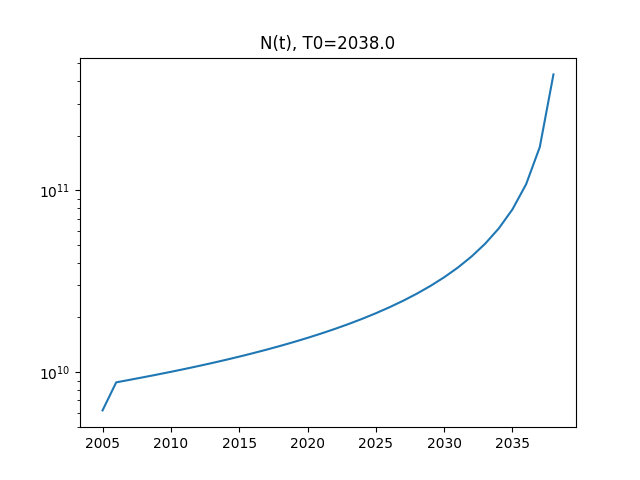

In [33]:
fig,ax = plt.subplots()
sums_ = [np.sum(el) for el in u_vec2]
ax.plot(years_[:len(u_vec2)], sums_)
ax.set_yscale('log')
ax.set_title(f'N(t), T0={years_[len(u_vec2)-1]}')

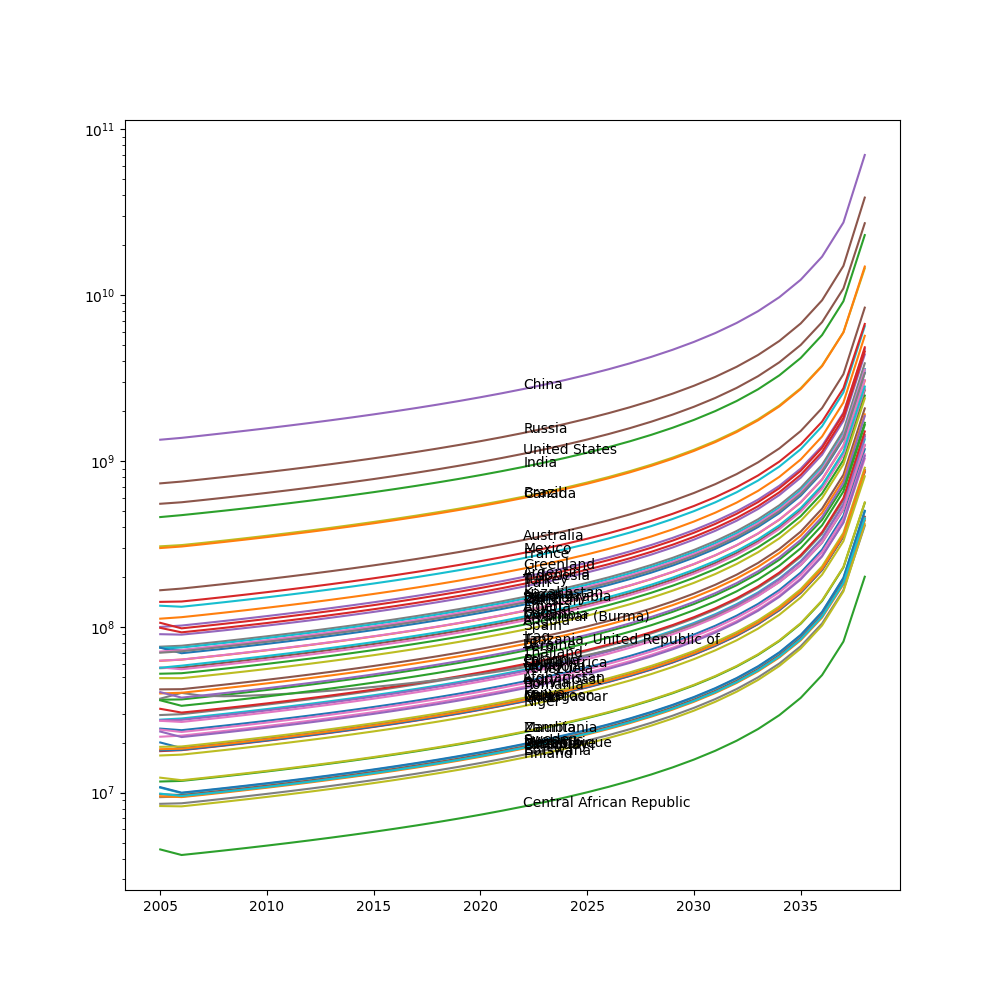

In [34]:
t_ = years_[:len(u_vec2)]
fig,ax = plt.subplots()
fig.set_size_inches(10,10)
for i in range(len(internal_mask_per_state)):
    mask_ = internal_mask_per_state[i]
    name_ = internal_index_cnames_[i]
    sums_ = []
    for j in range(len(u_vec2)):
        u_ = u_vec2[j]
        sum_ = np.sum(u_*mask_)
        sums_.append(sum_)
    ax.plot(t_,sums_)
    ax.text(t_[int(len(t_)/2)], sums_[int(len(sums_)/2)], name_, fontsize = 10) 
ax.set_yscale('log')

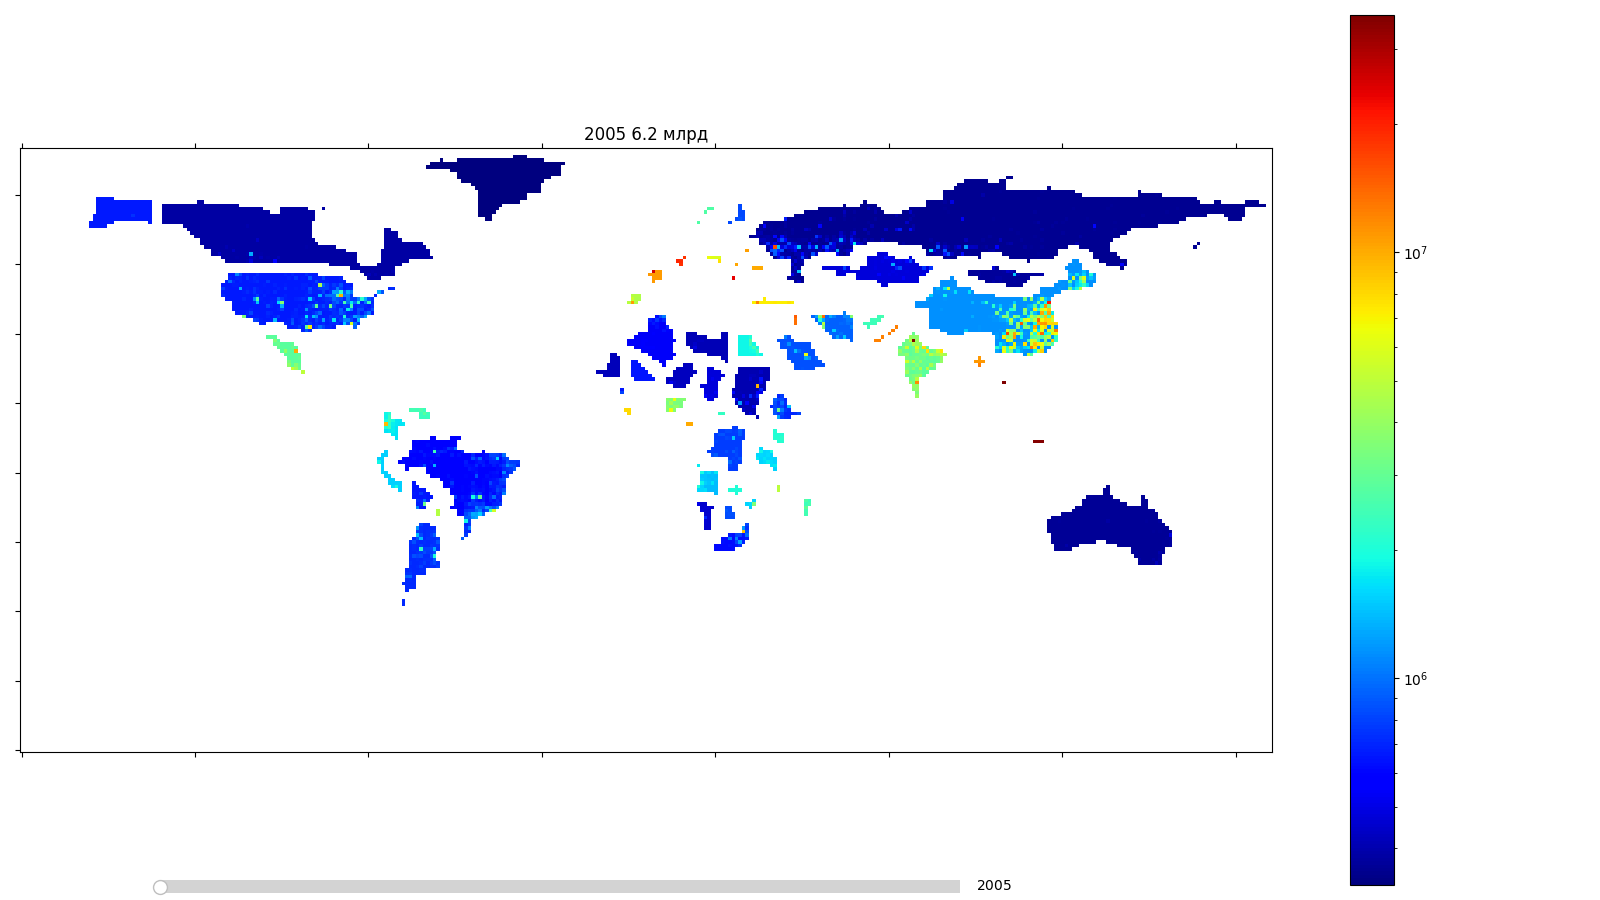

In [35]:
years_ = np.arange(t0,T+t0)
years_ = years_[:len(u_vec2)]
fig2, ax2 = plt.subplots()
ax2.set_xticklabels([])
ax2.set_yticklabels([])
fig2.set_size_inches(16,9)
cax = ax2.matshow(u_vec2[0].T,cmap=matplotlib.cm.jet,norm=matplotlib.colors.LogNorm())
# cax = ax2.matshow(u_vec2[0].T,cmap=matplotlib.cm.jet,norm=matplotlib.colors.SymLogNorm(linthresh=1))
ax2.set_title(f'{int(years_[0])} {np.round(np.sum(u_vec2[0])/10**9,1)} млрд')
ax2.invert_yaxis()
fig2.subplots_adjust(left=0.0, bottom=0.0)
cbar = fig.colorbar(cax)
fig2.tight_layout()

axfreq = fig2.add_axes([0.1, 0.0, 0.5, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='',
    valmin=years_[0],
    valmax=years_[-1],
    valinit=years_[0]
)

def update(val):
    # ax.matshow(u_vec[int(val- years_[0])].T,cmap=matplotlib.cm.jet,norm=matplotlib.colors.LogNorm())
    u_tmp = np.copy(u_vec2[int(val- years_[0])])
    # u_tmp[np.abs(u_tmp) <  = 0.0
    cax.set_data(u_tmp.T)
    ax2.set_title(f'{int(val)} {np.round(np.sum(u_tmp)/10**9,1)} млрд')
    fig.canvas.draw_idle()
    # plt.draw()
freq_slider.on_changed(update)
plt.show()

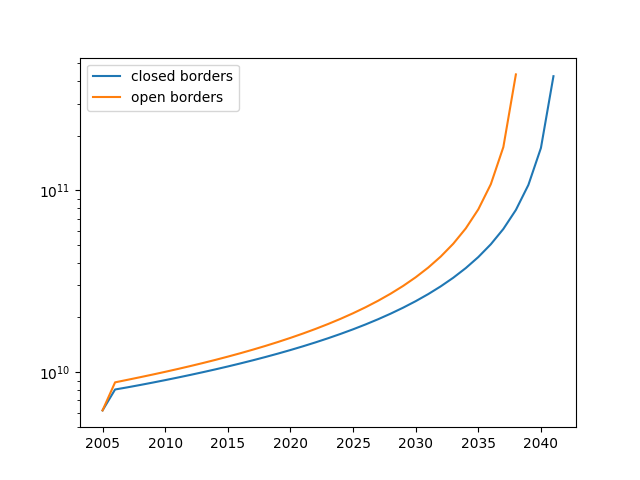

In [36]:
fig,ax = plt.subplots()
years_ = np.arange(t0,T+t0)
sums_1 = [np.sum(el) for el in u_vec]
sums_2= [np.sum(el) for el in u_vec2]
ax.plot(years_[:len(u_vec)], sums_1,label='closed borders')
ax.plot(years_[:len(u_vec2)], sums_2,label='open borders')
ax.set_yscale('log')
# ax.set_title(f'N(t), T0={years_[len(u_vec2)-1]}')
plt.legend()